In [1]:
import json
import pickle
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('../')
from l1000_evaluation_utils import compute_max_similarity
from tqdm import tqdm
import heapq
import operator

In [2]:
l1000_df = pd.read_csv("/data/ongh0068/l1000/l1000_biaae/lincs/experiments_filtered.csv", index_col=0)
l1000_df

CellLine  Time   Dose  \
Unnamed: 0                         
0              A375   6.0  10.00   
1              A549   6.0  10.00   
2              A549  24.0  10.00   
3               ASC  24.0  10.00   
4              HA1E   6.0  10.00   
...             ...   ...    ...   
187037         VCAP  24.0   4.96   
187038         VCAP   6.0   5.01   
187039         VCAP  24.0   5.01   
187040         VCAP   6.0   5.04   
187041         VCAP  24.0   5.04   

                                               ControlIndices  \
Unnamed: 0                                                      
0           12373 12374 12375 12376 12377 12378 12379 1238...   
1           12471 12472 12473 12474 12475 12476 12477 1247...   
2           12529 12530 12531 12532 12533 12534 12535 1253...   
3           12626 12627 12628 12629 12630 12631 12632 1263...   
4           3875 3876 3877 3878 3879 3880 3881 3882 3883 3...   
...                                                       ...   
187037      17239 17240 17241 17242 17243 17244 17245 1724...   
187038      18703 18704 18705 18706 18707 18708 18709 1871...   
187039      17239 17240 17241 17242 17243 17244 17245 1724...   
187040      18703 18704 18705 18706 18707 18708 18709 1871...   
187041      17239 17240 17241 17242 17243 17244 17245 1724...   

                          TumourIndices  \
Unnamed: 0                                
0                  343818 343819 343820   
1                         346328 346329   
2                  349439 349440 349441   
3           352969 352970 352971 352972   
4                           82857 82858   
...                                 ...   
187037             475303 475304 475305   
187038             467715 467716 467717   
187039             475309 475310 475311   
187040             467720 467721 467722   
187041             475315 475316 475317   

                                                       SMILES  \
Unnamed: 0                                                      
0                   CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1   
1                   CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1   
2                   CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1   
3                   CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1   
4                   CC1CS(=O)(=O)CCN1N=Cc1ccc([N+](=O)[O-])o1   
...                                                       ...   
187037      CC=Cc1ccc2n(c1=O)CC1C(CO)C(C(=O)NC(C)c3ccccc3)...   
187038      CC=Cc1ccc2n(c1=O)CC1C(CO)C(C(=O)NCCc3cn(C)cn3)...   
187039      CC=Cc1ccc2n(c1=O)CC1C(CO)C(C(=O)NCCc3cn(C)cn3)...   
187040      CC=Cc1ccc2n(c1=O)CC1C(CO)C(C(=O)NCC)N(Cc3ccccc...   
187041      CC=Cc1ccc2n(c1=O)CC1C(CO)C(C(=O)NCC)N(Cc3ccccc...   

            DrugIndex_maccs  DrugIndex_pharmacophore2d720  DrugIndex_morgan  \
Unnamed: 0                                                                    
0                      6172                          1394               918   
1                      6172                          1394               918   
2                      6172                          1394               918   
3                      6172                          1394               918   
4                      6172                          1394               918   
...                     ...                           ...               ...   
187037                 6652                          3995              8878   
187038                 6668                          3869               872   
187039                 6668                          3869               872   
187040                  535                          6817              8409   
187041                  535                          6817              8409   

            DrugIndex_morgan,pharmacophore2d720  ...  \
Unnamed: 0                                       ...   
0                                           919  ...   
1                                           919  ...   
2                                     

In [3]:
with open("/data/ongh0068/l1000/l1000_biaae/protein_target_to_l1000_smiles.pkl", 'rb') as f:
    meta_data = pickle.load(f)
meta_data

{'AKT1': ['CS(=O)c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)cc1',
  'Cn1cc(C2=C(c3cn(CCCSC(=N)N)c4ccccc34)C(=O)NC2=O)c2ccccc21',
  'CCC(CO)Nc1nc(NCc2ccccc2)c2ncn(C(C)C)c2n1',
  'O=c1cc(N2CCOCC2)oc2c(-c3ccccc3)cccc12',
  'O=C1NC(=O)C(c2c[nH]c3ccccc23)=C1c1c[nH]c2ccccc12',
  'COc1cc2ncnc(Nc3ccc(Oc4ccccc4)cc3)c2cc1OC',
  'O=C(c1ccccc1)c1ccc(N2CCOCC2)cc1O',
  'C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1',
  'O=C(Nc1cccc(Cl)c1)Nc1ncc(CCNc2ncnc3ccsc23)s1',
  'CN1CCC(c2c(O)cc(O)c3c(=O)cc(-c4ccccc4Cl)oc23)C(O)C1',
  'O=[N+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)cc1'],
 'AKT2': ['CS(=O)c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)cc1',
  'Cn1cc(C=C2C(=O)Nc3cccnc32)c2ccccc21',
  'CCC(CO)Nc1nc(NCc2ccccc2)c2ncn(C(C)C)c2n1',
  'COC(C(=O)N1Cc2[nH]nc(NC(=O)c3ccc(N4CCN(C)CC4)cc3)c2C1)c1ccccc1',
  'O=c1cc(N2CCOCC2)oc2c1ccc1ccccc12',
  'COc1cc(OC)c(C=C2C(=O)Nc3ccccc32)c(OC)c1',
  'Nc1nc(Nc2ccc(S(N)(=O)=O)cc2)nn1C(=O)c1c(F)cccc1F',
  'N#CC(=Cc1ccc(O)c(O)c1)C(=O)NCc1ccccc1',
  'COc1cc(Nc2ncc(F)c(Nc

In [4]:
with open("../test_set_sim_search.pkl", "rb") as f:
    test_set_smiles_to_train_set_diff_vector_and_distance = pickle.load(f)
test_set_smiles_to_train_set_diff_vector_and_distance

{'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_0': {'min_euclidean_dist': {'smile': 'CNC(=O)Oc1ccc2c(c1)C1(C)CCN(C)C1N2C_4356',
   'dist': 7.569423},
  'min_cosine_sim': {'smile': 'CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc(Cl)cc32)c1C_51119',
   'dist': -4.50906e-06},
  'max_cosine_sim': {'smile': 'COc1ccccc1N1CCN(CCCCN2C(=O)c3ccccc3C2=O)CC1_58004',
   'dist': 2.869751e-06}},
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_1': {'min_euclidean_dist': {'smile': 'CN(CCOc1ccc(CC2SC(=O)NC2=O)cc1)c1ccccn1_10031',
   'dist': 6.8265467},
  'min_cosine_sim': {'smile': 'CC(=O)C(C#N)C(=O)Nc1cc(Br)ccc1Br_3570',
   'dist': -1.1796407e-06},
  'max_cosine_sim': {'smile': 'OC1(c2ccc(Cl)c(C(F)(F)F)c2)CCN(CCCC(c2ccc(F)cc2)c2ccc(F)cc2)CC1_21393',
   'dist': 1.384695e-06}},
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_2': {'min_euclidean_dist': {'smile': 'CC1(C)SC2C(N=CN3CCCCCC3)C(=O)N2C1C(=O)O_37665',
   'dist': 7.199553},
  'min_cosine_sim': {'smile': 'CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc(Cl)cc32)c1C_511

In [5]:
'''
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Chem import AllChem
from rdkit.Chem.Fraggle.FraggleSim import GetFraggleSimilarity
from rdkit import Chem
from tqdm import tqdm

eu_dist_similarities = {
    'ori_smiles':[],
    'dist_smiles':[],
    'm_fp_tanimoto_sim':[],
    'maccs_fp_tanimoto_sim':[],
    'fraggle_sims':[]
}

cosine_dist_similarities = {
    'ori_smiles':[],
    'dist_smiles':[],
    'm_fp_tanimoto_sim':[],
    'maccs_fp_tanimoto_sim':[],
    'fraggle_sims':[]
}


radius = 3
nBits = 1024

for test_set_smile_idx in tqdm(test_set_smiles_to_train_set_diff_vector_and_distance):
    try:
        test_set_smile = ''.join(test_set_smile_idx.rsplit('_', 1)[0])
        test_set_mol = Chem.MolFromSmiles(test_set_smile)

        test_set_smile_m_fp =  AllChem.GetMorganFingerprintAsBitVect(test_set_mol,radius=radius, nBits=nBits) 
        test_set_smile_maccs_fp = MACCSkeys.GenMACCSKeys(test_set_mol)
        
        # Euclidean distance
        eu_dist_smile = test_set_smiles_to_train_set_diff_vector_and_distance[test_set_smile_idx]['min_euclidean_dist']['smile'].rsplit('_', 1)[0]
        eu_dist_mol = Chem.MolFromSmiles(eu_dist_smile)

        eu_dist_smile_m_fp =  AllChem.GetMorganFingerprintAsBitVect(eu_dist_mol,radius=radius, nBits=nBits) 
        eu_dist_smile_maccs_fp = MACCSkeys.GenMACCSKeys(eu_dist_mol)

        m_fp_tanimoto_sim = DataStructs.TanimotoSimilarity(test_set_smile_m_fp, eu_dist_smile_m_fp)
        maccs_fp_tanimoto_sim = DataStructs.TanimotoSimilarity(test_set_smile_maccs_fp, eu_dist_smile_maccs_fp)
        fraggle_sim, match = GetFraggleSimilarity(test_set_mol,eu_dist_mol)

        eu_dist_similarities['ori_smiles'].append(test_set_smile)
        eu_dist_similarities['dist_smiles'].append(eu_dist_smile)
        eu_dist_similarities['m_fp_tanimoto_sim'].append(m_fp_tanimoto_sim)
        eu_dist_similarities['maccs_fp_tanimoto_sim'].append(maccs_fp_tanimoto_sim)
        eu_dist_similarities['fraggle_sims'].append(fraggle_sim)

        # Cosine distance
        cos_dist_smile = test_set_smiles_to_train_set_diff_vector_and_distance[test_set_smile_idx]['max_cosine_sim']['smile'].rsplit('_', 1)[0]
        cos_dist_mol = Chem.MolFromSmiles(cos_dist_smile)

        cos_dist_smile_m_fp =  AllChem.GetMorganFingerprintAsBitVect(cos_dist_mol,radius=radius, nBits=nBits) 
        cos_dist_smile_maccs_fp = MACCSkeys.GenMACCSKeys(cos_dist_mol)

        m_fp_tanimoto_sim = DataStructs.TanimotoSimilarity(test_set_smile_m_fp, cos_dist_smile_m_fp)
        maccs_fp_tanimoto_sim = DataStructs.TanimotoSimilarity(test_set_smile_maccs_fp, cos_dist_smile_maccs_fp)
        fraggle_sim, match = GetFraggleSimilarity(test_set_mol,cos_dist_mol)

        cosine_dist_similarities['ori_smiles'].append(test_set_smile)
        cosine_dist_similarities['dist_smiles'].append(cos_dist_smile)
        cosine_dist_similarities['m_fp_tanimoto_sim'].append(m_fp_tanimoto_sim)
        cosine_dist_similarities['maccs_fp_tanimoto_sim'].append(maccs_fp_tanimoto_sim)
        cosine_dist_similarities['fraggle_sims'].append(fraggle_sim)

    except Exception as e:
        print(e)

'''

"\nfrom rdkit import DataStructs\nfrom rdkit.Chem import MACCSkeys\nfrom rdkit.Chem import AllChem\nfrom rdkit.Chem.Fraggle.FraggleSim import GetFraggleSimilarity\nfrom rdkit import Chem\nfrom tqdm import tqdm\n\neu_dist_similarities = {\n    'ori_smiles':[],\n    'dist_smiles':[],\n    'm_fp_tanimoto_sim':[],\n    'maccs_fp_tanimoto_sim':[],\n    'fraggle_sims':[]\n}\n\ncosine_dist_similarities = {\n    'ori_smiles':[],\n    'dist_smiles':[],\n    'm_fp_tanimoto_sim':[],\n    'maccs_fp_tanimoto_sim':[],\n    'fraggle_sims':[]\n}\n\n\nradius = 3\nnBits = 1024\n\nfor test_set_smile_idx in tqdm(test_set_smiles_to_train_set_diff_vector_and_distance):\n    try:\n        test_set_smile = ''.join(test_set_smile_idx.rsplit('_', 1)[0])\n        test_set_mol = Chem.MolFromSmiles(test_set_smile)\n\n        test_set_smile_m_fp =  AllChem.GetMorganFingerprintAsBitVect(test_set_mol,radius=radius, nBits=nBits) \n        test_set_smile_maccs_fp = MACCSkeys.GenMACCSKeys(test_set_mol)\n        \n      

In [6]:
# tmp_df = pd.DataFrame(eu_dist_similarities)
# tmp_df['dist_type'] = 'euclidean_dist'
# tmp2_df = pd.DataFrame(cosine_dist_similarities)
# tmp2_df['dist_type'] = 'cosine_dist'

NameError: name 'eu_dist_similarities' is not defined

In [7]:
# tmp3_df = pd.read_csv("../test_set_similarity_search_structural_similarities.csv")
# tmp3_df = pd.concat((tmp_df, tmp2_df))
# tmp3_df

ori_smiles  \
0       COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1   
1       COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1   
2       COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1   
3       COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1   
4       COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1   
...                                           ...   
7670  CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)ncnc21   
7671  CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)ncnc21   
7672  CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)ncnc21   
7673  CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)ncnc21   
7674  CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)ncnc21   

                                            dist_smiles  m_fp_tanimoto_sim  \
0                   CNC(=O)Oc1ccc2c(c1)C1(C)CCN(C)C1N2C           0.098214   
1               CN(CCOc1ccc(CC2SC(=O)NC2=O)cc1)c1ccccn1           0.092437   
2               CC1(C)SC2C(N=CN3CCCCCC3)C(=O)N2C1C(=O)O           0.110092   
3                       CC(C)(C)NCC(O)COc1nsnc1N1CCOCC1           0.180952   
4                           OC1CCCCC1N1CCC(c2ccccc2)CC1           0.113402   
...                                                 ...                ...   
7670        COc1ccccc1N1CCN(CCCCN2C(=O)c3ccccc3C2=O)CC1           0.060345   
7671        COc1ccccc1N1CCN(CCCCN2C(=O)c3ccccc3C2=O)CC1           0.060345   
7672  COC(=O)c1ccc(C2c3[nH]c4ccccc4c3CC(C(=O)OC)N2C(...           0.096000   
7673  COC(=O)c1ccc(C2c3[nH]c4ccccc4c3CC(C(=O)OC)N2C(...           0.096000   
7674  COC(=O)c1ccc(C2c3[nH]c4ccccc4c3CC(C(=O)OC)N2C(...           0.096000   

      maccs_fp_tanimoto_sim  fraggle_sims       dist_type  
0                  0.472222      0.627219  euclidean_dist  
1                  0.567568      0.494118  euclidean_dist  
2                  0.460526      0.237668  euclidean_dist  
3                  0.578313      0.796875  euclidean_dist  
4                  0.654545      0.685484  euclidean_dist  
...                     ...           ...             ...  
7670               0.455882      0.243346     cosine_dist  
7671               0.455882      0.243346     cosine_dist  
7672               0.405797      0.315113     cosine_dist  
7673               0.405797      0.315113     cosine_dist  
7674               0.405797      0.315113     cosine_dist  

[15350 rows x 6 columns]

In [5]:
# tmp3_df.to_csv("../test_set_similarity_search_structural_similarities_with_smiles.csv")
tmp3_df = pd.read_csv('../test_set_similarity_search_structural_similarities_with_smiles.csv', index_col=0)
tmp3_df

ori_smiles  \
0       COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1   
1       COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1   
2       COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1   
3       COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1   
4       COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1   
...                                           ...   
7670  CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)ncnc21   
7671  CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)ncnc21   
7672  CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)ncnc21   
7673  CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)ncnc21   
7674  CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)ncnc21   

                                            dist_smiles  m_fp_tanimoto_sim  \
0                   CNC(=O)Oc1ccc2c(c1)C1(C)CCN(C)C1N2C           0.098214   
1               CN(CCOc1ccc(CC2SC(=O)NC2=O)cc1)c1ccccn1           0.092437   
2               CC1(C)SC2C(N=CN3CCCCCC3)C(=O)N2C1C(=O)O           0.110092   
3                       CC(C)(C)NCC(O)COc1nsnc1N1CCOCC1           0.180952   
4                           OC1CCCCC1N1CCC(c2ccccc2)CC1           0.113402   
...                                                 ...                ...   
7670        COc1ccccc1N1CCN(CCCCN2C(=O)c3ccccc3C2=O)CC1           0.060345   
7671        COc1ccccc1N1CCN(CCCCN2C(=O)c3ccccc3C2=O)CC1           0.060345   
7672  COC(=O)c1ccc(C2c3[nH]c4ccccc4c3CC(C(=O)OC)N2C(...           0.096000   
7673  COC(=O)c1ccc(C2c3[nH]c4ccccc4c3CC(C(=O)OC)N2C(...           0.096000   
7674  COC(=O)c1ccc(C2c3[nH]c4ccccc4c3CC(C(=O)OC)N2C(...           0.096000   

      maccs_fp_tanimoto_sim  fraggle_sims       dist_type  
0                  0.472222      0.627219  euclidean_dist  
1                  0.567568      0.494118  euclidean_dist  
2                  0.460526      0.237668  euclidean_dist  
3                  0.578313      0.796875  euclidean_dist  
4                  0.654545      0.685484  euclidean_dist  
...                     ...           ...             ...  
7670               0.455882      0.243346     cosine_dist  
7671               0.455882      0.243346     cosine_dist  
7672               0.405797      0.315113     cosine_dist  
7673               0.405797      0.315113     cosine_dist  
7674               0.405797      0.315113     cosine_dist  

[15350 rows x 6 columns]

Text(0.5, 1.0, 'Test Set Similarity Search: Morgan Fingerprint Tanimoto Similarity')

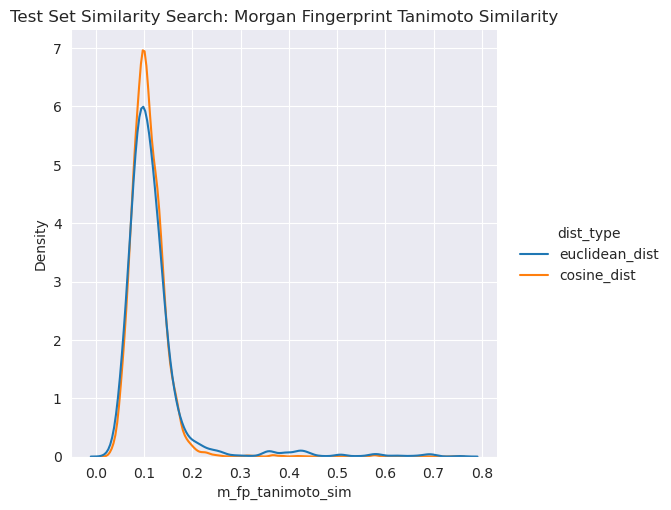

In [7]:
sns.set_style('darkgrid')
sns.displot(tmp3_df,x = 'm_fp_tanimoto_sim',  hue="dist_type", kind = 'kde')

plt.title('Test Set Similarity Search: Morgan Fingerprint Tanimoto Similarity')

In [6]:
with open("cond_generation_res/ldm_con_vae_test_set_smile_to_max_sim_generated_molecule.pkl", "rb") as f:
    ldm_vae_data = pickle.load(f)

In [7]:
ldm_vae_data

{'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_159': {'max_morgan_fp_tanimoto_sim': 0.18556701030927836,
  'max_maccs_fp_tanimoto_sim': 0.5925925925925926,
  'max_fraggle_sim': 0.6614173228346457},
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_163': {'max_morgan_fp_tanimoto_sim': 0.2909090909090909,
  'max_maccs_fp_tanimoto_sim': 0.7164179104477612,
  'max_fraggle_sim': 0.8015267175572519},
 'CCC(=O)NC(c1ccco1)c1cc(Br)c2cccnc2c1O_202': {'max_morgan_fp_tanimoto_sim': 0.1724137931034483,
  'max_maccs_fp_tanimoto_sim': 0.5517241379310345,
  'max_fraggle_sim': 0.5406976744186046},
 'CCC(=O)NC(c1ccco1)c1cc(Br)c2cccnc2c1O_206': {'max_morgan_fp_tanimoto_sim': 0.2345679012345679,
  'max_maccs_fp_tanimoto_sim': 0.5409836065573771,
  'max_fraggle_sim': 0.5732484076433121},
 'CC(C)(C)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccccc3)CC2)cc1_631': {'max_morgan_fp_tanimoto_sim': 0.20481927710843373,
  'max_maccs_fp_tanimoto_sim': 0.56,
  'max_fraggle_sim': 0.47715736040609136},
 'CC(C)(C)c1ccc(C(O)CCCN2CCC(C(O)

In [8]:
len(ldm_vae_data)

332

In [9]:
with open("cond_generation_res/ldm_con_aae_test_set_smile_to_max_sim_generated_molecule.pkl", "rb") as f:
    ldm_aae_data = pickle.load(f)
    


In [10]:
ldm_aae_data

{'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_159': {'max_morgan_fp_tanimoto_sim': 0.18584070796460178,
  'max_maccs_fp_tanimoto_sim': 0.703125,
  'max_fraggle_sim': 0.635036496350365},
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_163': {'max_morgan_fp_tanimoto_sim': 0.2037037037037037,
  'max_maccs_fp_tanimoto_sim': 0.7424242424242424,
  'max_fraggle_sim': 0.7922077922077922},
 'CCC(=O)NC(c1ccco1)c1cc(Br)c2cccnc2c1O_202': {'max_morgan_fp_tanimoto_sim': 0.1780821917808219,
  'max_maccs_fp_tanimoto_sim': 0.5714285714285714,
  'max_fraggle_sim': 0.6170212765957447},
 'CCC(=O)NC(c1ccco1)c1cc(Br)c2cccnc2c1O_206': {'max_morgan_fp_tanimoto_sim': 0.16541353383458646,
  'max_maccs_fp_tanimoto_sim': 0.5652173913043478,
  'max_fraggle_sim': 0.7198067632850241},
 'CC(C)(C)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccccc3)CC2)cc1_631': {'max_morgan_fp_tanimoto_sim': 0.17177914110429449,
  'max_maccs_fp_tanimoto_sim': 0.5797101449275363,
  'max_fraggle_sim': 0.5333333333333333},
 'CC(C)(C)c1ccc(C(O)CCCN2CCC(C

In [11]:
with open("cond_generation_res/ldm_con_wae_test_set_smile_to_max_sim_generated_molecule.pkl", "rb") as f:
    ldm_wae_data = pickle.load(f)

In [12]:
print(len(ldm_wae_data))
ldm_wae_data

332


{'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_159': {'max_morgan_fp_tanimoto_sim': 0.18248175182481752,
  'max_maccs_fp_tanimoto_sim': 0.7076923076923077,
  'max_fraggle_sim': 0.6692913385826772},
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_163': {'max_morgan_fp_tanimoto_sim': 0.18181818181818182,
  'max_maccs_fp_tanimoto_sim': 0.71875,
  'max_fraggle_sim': 0.6235294117647059},
 'CCC(=O)NC(c1ccco1)c1cc(Br)c2cccnc2c1O_202': {'max_morgan_fp_tanimoto_sim': 0.16153846153846155,
  'max_maccs_fp_tanimoto_sim': 0.6229508196721312,
  'max_fraggle_sim': 0.6532663316582915},
 'CCC(=O)NC(c1ccco1)c1cc(Br)c2cccnc2c1O_206': {'max_morgan_fp_tanimoto_sim': 0.15463917525773196,
  'max_maccs_fp_tanimoto_sim': 0.5652173913043478,
  'max_fraggle_sim': 0.569672131147541},
 'CC(C)(C)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccccc3)CC2)cc1_631': {'max_morgan_fp_tanimoto_sim': 0.25842696629213485,
  'max_maccs_fp_tanimoto_sim': 0.6415094339622641,
  'max_fraggle_sim': 0.5068493150684932},
 'CC(C)(C)c1ccc(C(O)CCCN2CCC(

In [13]:
# ldm_vae_data = {k:ldm_vae_data[k] for k in list(ldm_vae_data)[:78]}
# ldm_wae_data = {k:ldm_wae_data[k] for k in list(ldm_wae_data)[:78]}
print(len(ldm_vae_data), len(ldm_aae_data), len(ldm_wae_data))

332 332 332


In [14]:
with open('/data/conghao001/FYP/drug_discovery/BiAAE/cond_generation_res/biaae_test_set_smile_to_max_sim_generated_molecule.pkl', 'rb') as f:
    biaae_data = pickle.load(f)
len(biaae_data)

419

In [17]:
# ldm_aae_data = {k:ldm_aae_data[k] for k in list(ldm_aae_data)[:862]}
# len(ldm_aae_data)

# biaae_data = {k:v for k, v in biaae_data.items() if k in ldm_vae_data.keys()}
# len(biaae_data)

# Filter similarity search

In [15]:
# keys = list(ldm_vae_data.keys())

keys = [k for k in ldm_vae_data.keys() if k in biaae_data.keys()]
len(keys)

332

In [16]:
aae_smiles = [k.split('_')[0] for k in keys]
aae_smiles = list(set(aae_smiles))
len(aae_smiles)

197

In [17]:
ldm_vae_data = {k:ldm_vae_data[k] for k in keys}
ldm_aae_data = {k:ldm_aae_data[k] for k in keys}
ldm_wae_data = {k:ldm_wae_data[k] for k in keys}
biaae_data = {k:biaae_data[k] for k in keys}

print(len(ldm_vae_data), len(ldm_wae_data), len(biaae_data))

332 332 332


In [18]:
from collections import defaultdict
aae_num = defaultdict(lambda: 0)
for k in keys:
    smi = k.split('_')[0]
    aae_num[smi] += 1

aae_num

defaultdict(<function __main__.<lambda>()>,
            {'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1': 2,
             'CCC(=O)NC(c1ccco1)c1cc(Br)c2cccnc2c1O': 2,
             'CC(C)(C)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccccc3)CC2)cc1': 2,
             'COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C)cc1OC': 2,
             'CC[N+](C)(CC)CCOC(=O)C(O)(c1ccccc1)C1CCCCC1': 2,
             'O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1': 2,
             'NS(=O)(=O)c1cc(C2(O)NC(=O)c3ccccc32)ccc1Cl': 2,
             'COc1ccc(C2CC(c3ccccc3)=NN2c2ccc(S(N)(=O)=O)cc2)cc1': 2,
             'CS(=O)c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)cc1': 1,
             'Cc1ccc(S(=O)(=O)C(c2ccccc2)c2c(C)noc2C)cc1': 1,
             'CNC(=O)Nc1ccc(-c2nc(N3CC4CCC(C3)O4)c3cnn(C4CCC5(CC4)OCCO5)c3n2)cc1': 2,
             'CC(C)C(=O)NC(c1ccco1)c1ccc2cccnc2c1O': 2,
             'Cc1ccccc1C(OCCN(C)C)c1ccccc1': 1,
             'CC(=O)NC(c1ccco1)c1cc(Cl)c2cccnc2c1O': 2,
             'CC(=O)NC(c1cccs1)c1cc(Br)c2cccnc2c1O': 2,
 

In [19]:
# sim_search = {k:test_set_smiles_to_train_set_diff_vector_and_distance[k] for k in keys}
# sim_search

In [20]:
aae_df = tmp3_df.loc[tmp3_df['ori_smiles'].isin(aae_smiles)]
aae_df

ori_smiles  \
0       COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1   
1       COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1   
2       COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1   
3       COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1   
4       COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1   
...                                           ...   
7670  CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)ncnc21   
7671  CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)ncnc21   
7672  CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)ncnc21   
7673  CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)ncnc21   
7674  CC(C)n1nc(-c2cc3cc(O)ccc3[nH]2)c2c(N)ncnc21   

                                            dist_smiles  m_fp_tanimoto_sim  \
0                   CNC(=O)Oc1ccc2c(c1)C1(C)CCN(C)C1N2C           0.098214   
1               CN(CCOc1ccc(CC2SC(=O)NC2=O)cc1)c1ccccn1           0.092437   
2               CC1(C)SC2C(N=CN3CCCCCC3)C(=O)N2C1C(=O)O           0.110092   
3                       CC(C)(C)NCC(O)COc1nsnc1N1CCOCC1           0.180952   
4                           OC1CCCCC1N1CCC(c2ccccc2)CC1           0.113402   
...                                                 ...                ...   
7670        COc1ccccc1N1CCN(CCCCN2C(=O)c3ccccc3C2=O)CC1           0.060345   
7671        COc1ccccc1N1CCN(CCCCN2C(=O)c3ccccc3C2=O)CC1           0.060345   
7672  COC(=O)c1ccc(C2c3[nH]c4ccccc4c3CC(C(=O)OC)N2C(...           0.096000   
7673  COC(=O)c1ccc(C2c3[nH]c4ccccc4c3CC(C(=O)OC)N2C(...           0.096000   
7674  COC(=O)c1ccc(C2c3[nH]c4ccccc4c3CC(C(=O)OC)N2C(...           0.096000   

      maccs_fp_tanimoto_sim  fraggle_sims       dist_type  
0                  0.472222      0.627219  euclidean_dist  
1                  0.567568      0.494118  euclidean_dist  
2                  0.460526      0.237668  euclidean_dist  
3                  0.578313      0.796875  euclidean_dist  
4                  0.654545      0.685484  euclidean_dist  
...                     ...           ...             ...  
7670               0.455882      0.243346     cosine_dist  
7671               0.455882      0.243346     cosine_dist  
7672               0.405797      0.315113     cosine_dist  
7673               0.405797      0.315113     cosine_dist  
7674               0.405797      0.315113     cosine_dist  

[13450 rows x 6 columns]

In [21]:
aae_euc = aae_df.loc[aae_df['dist_type']=='euclidean_dist']
aae_cos = aae_df.loc[aae_df['dist_type']=='cosine_dist']

### sample according to the occurance times of each ref smile
-> result in same number of scores with generated ones

In [22]:
sample_df = pd.DataFrame(columns = aae_df.columns)
sample_df

Empty DataFrame
Columns: [ori_smiles, dist_smiles, m_fp_tanimoto_sim, maccs_fp_tanimoto_sim, fraggle_sims, dist_type]
Index: []

In [23]:
for smi in aae_smiles:
    df_euc = aae_euc.loc[aae_euc['ori_smiles']==smi].sample(n=aae_num[smi])
    df_cos = aae_cos.loc[aae_cos['ori_smiles']==smi].sample(n=aae_num[smi])
    
    sample_df = pd.concat([sample_df, df_euc, df_cos])
    
sample_df

ori_smiles  \
417    O=C(NC1CCCCC1)C(c1cccnc1)N(C(=O)CCl)c1cccc(Cl)c1   
420    O=C(NC1CCCCC1)C(c1cccnc1)N(C(=O)CCl)c1cccc(Cl)c1   
439                O=C(c1ccc(F)cc1)C(CN1CCOCC1)c1ccccc1   
453                O=C(c1ccc(F)cc1)C(CN1CCOCC1)c1ccccc1   
449                O=C(c1ccc(F)cc1)C(CN1CCOCC1)c1ccccc1   
...                                                 ...   
4784  CCC1C(=O)N(C)c2cnc(Nc3ccc(C(=O)NC4CCN(C)CC4)cc...   
4097  CCCCn1c(CN2CCN(c3cccc(Cl)c3)CC2)nc2c1c(=O)n(C)...   
4088  CCCCn1c(CN2CCN(c3cccc(Cl)c3)CC2)nc2c1c(=O)n(C)...   
4087  CCCCn1c(CN2CCN(c3cccc(Cl)c3)CC2)nc2c1c(=O)n(C)...   
4085  CCCCn1c(CN2CCN(c3cccc(Cl)c3)CC2)nc2c1c(=O)n(C)...   

                                            dist_smiles  m_fp_tanimoto_sim  \
417   COc1ccc(C(C(=O)NC2CCCCC2)N(C(=O)CCl)c2cccc(Cl)...           0.655172   
420   O=C(Nc1cccc(NC(=O)c2cc([N+](=O)[O-])ccc2Cl)n1)...           0.132075   
439               Cc1c(N=Cc2cc(Br)cc(Br)c2O)cccc1C(=O)O           0.104167   
453                   Cc1nccn1CC1CCc2c(c3ccccc3n2C)C1=O           0.095238   
449                 COc1ccc(Cn2ccc3ccc(C(=O)NO)cc32)cc1           0.125000   
...                                                 ...                ...   
4784  O=C(CC1CCC2C(COCC(O)CN2C(=O)c2ccncc2)O1)Nc1ccc...           0.118750   
4097      Fc1cccc(CNc2ncnc3ccc(-c4ccc5c(c4)OCO5)cc23)c1           0.065217   
4088  Cc1c(C)c2c(c(C)c1O)CCC(C)(COc1ccc(CC3SC(=O)NC3...           0.080882   
4087        COc1ccccc1N1CCN(CCCCN2C(=O)c3ccccc3C2=O)CC1           0.189189   
4085          Cc1[nH]c2ccccc2c1CCNCc1ccc(C=CC(=O)NO)cc1           0.060606   

      maccs_fp_tanimoto_sim  fraggle_sims       dist_type  
417                0.735849      1.000000  euclidean_dist  
420                0.468750      0.362245     cosine_dist  
439                0.290909      0.373057  euclidean_dist  
453                0.431034      0.433476  euclidean_dist  
449                0.313433      0.455497     cosine_dist  
...                     ...           ...             ...  
4784               0.628205      0.545455     cosine_dist  
4097               0.454545      0.326460  euclidean_dist  
4088               0.454545      0.354386  euclidean_dist  
4087               0.718310      0.321656     cosine_dist  
4085               0.416667      0.340351     cosine_dist  

[664 rows x 6 columns]

### select the median score for each smiles
-> each ref smiles only has one score

In [24]:
ref_dict = {smi:{'morgan':0.0, 'maccs':0.0, 'fraggle':0.0} for smi in aae_smiles}
ref_df = pd.DataFrame(ref_dict).T
ref_df

morgan  maccs  fraggle
O=C(NC1CCCCC1)C(c1cccnc1)N(C(=O)CCl)c1cccc(Cl)c1       0.0    0.0      0.0
O=C(c1ccc(F)cc1)C(CN1CCOCC1)c1ccccc1                   0.0    0.0      0.0
Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(CC...     0.0    0.0      0.0
CCCCC1C(=O)N(c2ccccc2)N(c2ccc(O)cc2)C1=O               0.0    0.0      0.0
CC(C)C(=O)NC(c1ccco1)c1ccc2cccnc2c1O                   0.0    0.0      0.0
...                                                    ...    ...      ...
COc1cc2nc(N3CCCN(C)CC3)nc(NC3CCN(Cc4ccccc4)CC3)...     0.0    0.0      0.0
OCC1OC(n2cnc3c(NCc4ccco4)ncnc32)C(O)C1O                0.0    0.0      0.0
COc1cc2ncnc(Nc3cccc(Cl)c3)c2cc1OC                      0.0    0.0      0.0
CCC1C(=O)N(C)c2cnc(Nc3ccc(C(=O)NC4CCN(C)CC4)cc3...     0.0    0.0      0.0
CCCCn1c(CN2CCN(c3cccc(Cl)c3)CC2)nc2c1c(=O)n(C)c...     0.0    0.0      0.0

[197 rows x 3 columns]

In [25]:
ref_df['morgan'] = aae_df.groupby(['ori_smiles'])['m_fp_tanimoto_sim'].median()
ref_df['maccs'] = aae_df.groupby(['ori_smiles'])['maccs_fp_tanimoto_sim'].median()
ref_df['fraggle'] = aae_df.groupby(['ori_smiles'])['fraggle_sims'].median()
ref_df

morgan     maccs  \
O=C(NC1CCCCC1)C(c1cccnc1)N(C(=O)CCl)c1cccc(Cl)c1    0.196581  0.560947   
O=C(c1ccc(F)cc1)C(CN1CCOCC1)c1ccccc1                0.128157  0.424242   
Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(CC...  0.133335  0.564404   
CCCCC1C(=O)N(c2ccccc2)N(c2ccc(O)cc2)C1=O            0.122940  0.411122   
CC(C)C(=O)NC(c1ccco1)c1ccc2cccnc2c1O                0.097345  0.444444   
...                                                      ...       ...   
COc1cc2nc(N3CCCN(C)CC3)nc(NC3CCN(Cc4ccccc4)CC3)...  0.114094  0.476754   
OCC1OC(n2cnc3c(NCc4ccco4)ncnc32)C(O)C1O             0.088710  0.478873   
COc1cc2ncnc(Nc3cccc(Cl)c3)c2cc1OC                   0.104348  0.362853   
CCC1C(=O)N(C)c2cnc(Nc3ccc(C(=O)NC4CCN(C)CC4)cc3...  0.134228  0.597561   
CCCCn1c(CN2CCN(c3cccc(Cl)c3)CC2)nc2c1c(=O)n(C)c...  0.111901  0.513393   

                                                     fraggle  
O=C(NC1CCCCC1)C(c1cccnc1)N(C(=O)CCl)c1cccc(Cl)c1    0.857143  
O=C(c1ccc(F)cc1)C(CN1CCOCC1)c1ccccc1                0.468799  
Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(CC...  0.368601  
CCCCC1C(=O)N(c2ccccc2)N(c2ccc(O)cc2)C1=O            0.384070  
CC(C)C(=O)NC(c1ccco1)c1ccc2cccnc2c1O                0.393857  
...                                                      ...  
COc1cc2nc(N3CCCN(C)CC3)nc(NC3CCN(Cc4ccccc4)CC3)...  0.371124  
OCC1OC(n2cnc3c(NCc4ccco4)ncnc32)C(O)C1O             0.329670  
COc1cc2ncnc(Nc3cccc(Cl)c3)c2cc1OC                   0.266427  
CCC1C(=O)N(C)c2cnc(Nc3ccc(C(=O)NC4CCN(C)CC4)cc3...  0.530303  
CCCCn1c(CN2CCN(c3cccc(Cl)c3)CC2)nc2c1c(=O)n(C)c...  0.335587  

[197 rows x 3 columns]

In [26]:
def extract_sims(data):
    max_morgan_fp_tanimoto_sim = [value['max_morgan_fp_tanimoto_sim'] for value in data.values()]
    max_maccs_fp_tanimoto_sim = [value['max_maccs_fp_tanimoto_sim'] for value in data.values()]
    max_fraggle_sim = [value['max_fraggle_sim'] for value in data.values()]
    return [max_morgan_fp_tanimoto_sim,max_maccs_fp_tanimoto_sim,max_fraggle_sim]

In [27]:
file_to_sims = {
#     "ldm_vae":extract_sims(ldm_vae_data),
#     "ldm_aae":extract_sims(ldm_aae_data),
#     "ldm_wae":extract_sims(ldm_wae_data),
#     "BiAAE":extract_sims(biaae_data),
    "GLDM":extract_sims(ldm_aae_data)
}

for key in file_to_sims:
    file_to_sims[key].append([key for _ in range(len(file_to_sims[key][0]))])

In [28]:
file_to_sims

{'GLDM': [[0.18584070796460178,
   0.2037037037037037,
   0.1780821917808219,
   0.16541353383458646,
   0.17177914110429449,
   0.19014084507042253,
   0.12254901960784313,
   0.15,
   0.16058394160583941,
   0.1981981981981982,
   0.14666666666666667,
   0.15702479338842976,
   0.15333333333333332,
   0.15217391304347827,
   0.18705035971223022,
   0.17687074829931973,
   0.13970588235294118,
   0.16101694915254236,
   0.19727891156462585,
   0.1865671641791045,
   0.15584415584415584,
   0.1484375,
   0.19101123595505617,
   0.14545454545454545,
   0.13636363636363635,
   0.15,
   0.15079365079365079,
   0.17197452229299362,
   0.13970588235294118,
   0.1875,
   0.16296296296296298,
   0.16083916083916083,
   0.15862068965517243,
   0.18620689655172415,
   0.1958762886597938,
   0.13725490196078433,
   0.1346153846153846,
   0.20863309352517986,
   0.211864406779661,
   0.12264150943396226,
   0.15079365079365079,
   0.18404907975460122,
   0.11864406779661017,
   0.125,
   0.214285

In [29]:
tmp3_df.shape

(15350, 6)

In [30]:
# euc_df = tmp3_df.loc[tmp3_df['dist_type']=='euclidean_dist'].iloc[:78]
# cos_df = tmp3_df.loc[tmp3_df['dist_type']=='cosine_dist'].iloc[:78]

# euc_df = tmp3_df.loc[tmp3_df['dist_type']=='euclidean_dist'].iloc[:862]
# cos_df = tmp3_df.loc[tmp3_df['dist_type']=='cosine_dist'].iloc[:862]

euc_df = sample_df[['m_fp_tanimoto_sim', 'maccs_fp_tanimoto_sim', 'fraggle_sims', 'dist_type']].loc[sample_df['dist_type']=='euclidean_dist']
cos_df = sample_df[['m_fp_tanimoto_sim', 'maccs_fp_tanimoto_sim', 'fraggle_sims', 'dist_type']].loc[sample_df['dist_type']=='cosine_dist']

In [31]:
dist_df = pd.concat([euc_df, cos_df])
dist_df

m_fp_tanimoto_sim  maccs_fp_tanimoto_sim  fraggle_sims       dist_type
417            0.655172               0.735849      1.000000  euclidean_dist
439            0.104167               0.290909      0.373057  euclidean_dist
453            0.095238               0.431034      0.433476  euclidean_dist
3015           0.122302               0.487500      0.278351  euclidean_dist
2998           0.081301               0.400000      0.250000  euclidean_dist
...                 ...                    ...           ...             ...
5258           0.093750               0.363636      0.281553     cosine_dist
4859           0.097403               0.368932      0.446735     cosine_dist
4784           0.118750               0.628205      0.545455     cosine_dist
4087           0.189189               0.718310      0.321656     cosine_dist
4085           0.060606               0.416667      0.340351     cosine_dist

[664 rows x 4 columns]

In [32]:
# ref_df = tmp3_df
dfs = []
for key in file_to_sims:
    new_df = pd.DataFrame(file_to_sims[key]).T
    new_df.columns = dist_df.columns
    dfs.append(new_df)

In [33]:
tgt = pd.concat(dfs + [dist_df])
tgt

m_fp_tanimoto_sim maccs_fp_tanimoto_sim fraggle_sims    dist_type
0             0.185841              0.703125     0.635036         GLDM
1             0.203704              0.742424     0.792208         GLDM
2             0.178082              0.571429     0.617021         GLDM
3             0.165414              0.565217     0.719807         GLDM
4             0.171779               0.57971     0.533333         GLDM
...                ...                   ...          ...          ...
5258           0.09375              0.363636     0.281553  cosine_dist
4859          0.097403              0.368932     0.446735  cosine_dist
4784           0.11875              0.628205     0.545455  cosine_dist
4087          0.189189               0.71831     0.321656  cosine_dist
4085          0.060606              0.416667     0.340351  cosine_dist

[996 rows x 4 columns]

In [34]:
print(sum(tgt['dist_type']=='ldm_aae'), sum(tgt['dist_type']=='ldm_vae'), sum(tgt['dist_type']=='ldm_wae'))

0 0 0


In [35]:
print(sum(tgt['dist_type']=='euclidean_dist'))
print(sum(tgt['dist_type']=='cosine_dist'))

332
332


Text(0.5, 1.0, 'Fraggle Similarity')

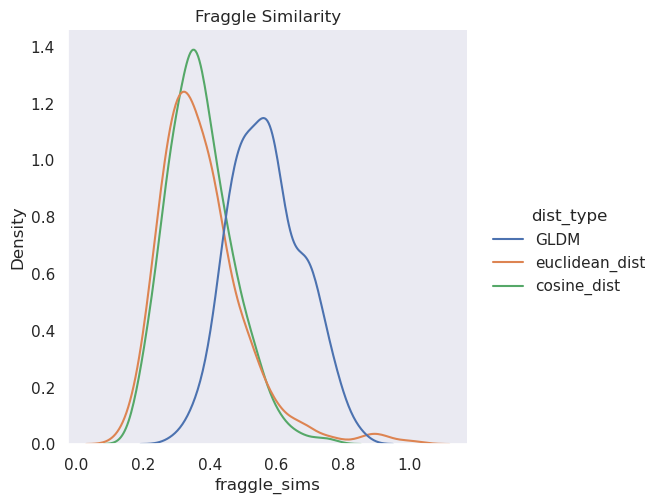

In [36]:
sns.set_theme()
sns.set_style("dark")
sns.displot(tgt,x = 'fraggle_sims',  hue="dist_type", kind = 'kde')


plt.title('Fraggle Similarity')
# plt.savefig('../test_set_similarity_search/aae_862.png', bbox_inches="tight")

Text(0.5, 1.0, 'Morgan fingerprint Tanimoto Similarity')

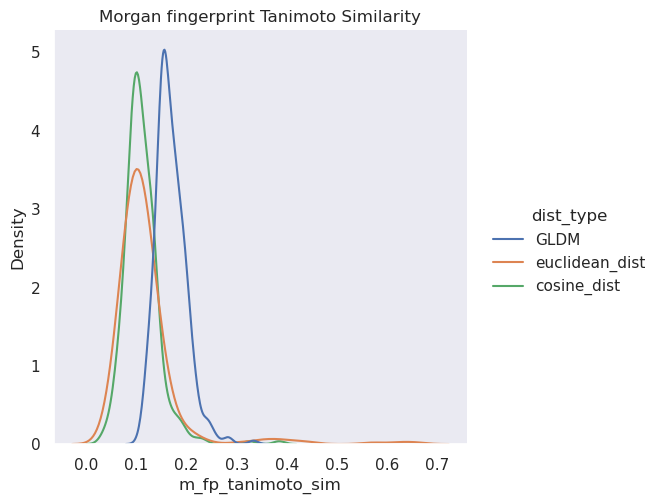

In [37]:
sns.displot(tgt,x = 'm_fp_tanimoto_sim',  hue="dist_type", kind = 'kde')
plt.title('Morgan fingerprint Tanimoto Similarity')
# plt.savefig('../plots/structural_sim_ldm/wrong_morgan_sims_1000.png', bbox_inches="tight")

In [38]:
sns.displot(tgt,x = 'maccs_fp_tanimoto_sim',  hue="dist_type", kind = 'kde')
plt.title('MACCS fingerprint Tanimoto Similarity')
# plt.savefig('../plots/structural_sim_ldm/wrong_maccs_sims_1000.png', bbox_inches="tight")

Text(0.5, 1.0, 'MACCS fingerprint Tanimoto Similarity')

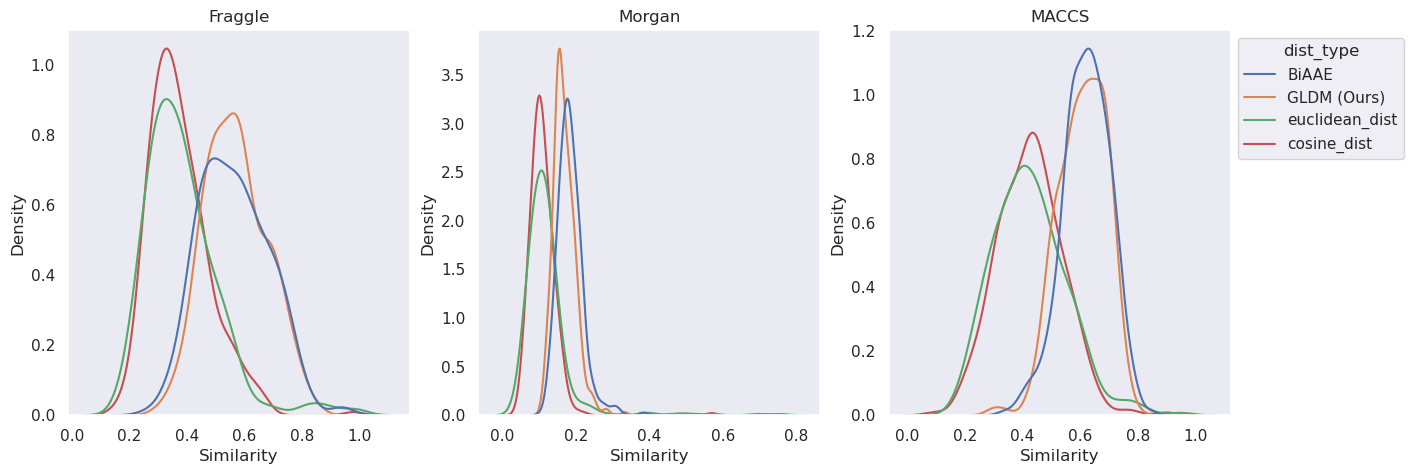

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
# print(axes)
sns.kdeplot(tgt,x = 'fraggle_sims',  hue="dist_type", ax=ax1)
# axes[0].set(title='Fraggle')
ax1.get_legend().remove()
ax1.set(xlabel='Similarity', title='Fraggle')

sns.kdeplot(tgt,x = 'm_fp_tanimoto_sim',  hue="dist_type", ax=ax2)
# axes[1].set(title='Morgan fingerprint Tanimoto Similarity')
ax2.get_legend().remove()
ax2.set(xlabel='Similarity', title='Morgan')


sns.kdeplot(tgt,x = 'maccs_fp_tanimoto_sim',  hue="dist_type", ax=ax3)
# axes[2].set(title='MACCS fingerprint Tanimoto Similarity')
ax3.set(xlabel='Similarity', title='MACCS')

sns.move_legend(ax3, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [43]:
fig.savefig('../test_set_similarity_search/test_set_rediscovery_correct_match.png', bbox_inches='tight')

## Retrieve data

In [2]:
with open("cond_generation_res/ldm_con_vae_generated_molecules_and_sa_scores.pkl", "rb") as f:
    ldm_vae_mols = pickle.load(f)
    
with open("cond_generation_res/ldm_con_aae_generated_molecules_and_sa_scores.pkl", "rb") as f:
    ldm_aae_mols = pickle.load(f)
    
with open("cond_generation_res/ldm_con_wae_generated_molecules_and_sa_scores.pkl", "rb") as f:
    ldm_wae_mols = pickle.load(f)

In [3]:
ldm_vae_mols

{'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_159': {'generated_mols': [<rdkit.Chem.rdchem.RWMol at 0x7fe7024ae5e0>,
  'generated_smiles': ['N',
   'C',
   'NC1=CC=CC=C1F',
   'N#CC1=CC=C(F)C=C1',
   'COC1=CC=C(F)C=C1',
   'N#CC1=CC=CC(Cl)=C1',
   'N#CCC1=CNC2=CC=CC=C12',
   'CC(N)CO',
   'CC(N)CO',
   'N#CC1=CC=C(N)C=C1Br',
   'COC1=CC=C(CN2CCCCC2)C=C1',
   'O=S(=O)(O)NNC1=CC=CC=C1Cl',
   'CN(C)CCCO',
   'O=CCSC1=NN=CO1',
   'CCOC1=C(Cl)C=CC=C1F',
   'COC1=CC=C(C(N)=O)C=C1',
   'COC1=CC=C(C#N)C=C1Br',
   'NCCNC1=CC=C(F)C=C1',
   'NNN=CC1=CC=C(F)C=C1',
   'CCC(=O)NC(C)C',
   'CC(N)C(=O)N1CCN(C)CC1',
   'CNN=CC1=CC=C(Br)C=C1O',
   'O=C(CCl)NC1=CC=CC=C1F',
   'O=C(CCl)NC1=CC=C(F)C=C1',
   'CCN(C)CC1=CC=CC=C1F',
   'CC(N)C=CC1=CC=C(O)C=C1',
   'CSCC(=O)C1=CC=C(F)C=C1',
   'O=C(O)C(CN1CCCC1)C1=CC=CC=C1',
   'CC1=C(C)C(C(=O)C2=CC=C(F)C=C2)=NO1',
   'CC(CC1=CC=C(Cl)C=C1)NC(=O)C1=CN=C2C=CC=CC2=C1',
   'CN(C)CC(=O)NCC1=CC=CC(Cl)=C1',
   'CN(C)C(=O)CC1=CC=CC=C1',
   'CCS(=O)(=O)OC1=CC=CC=C1',
   

In [4]:
def smiles2mol(data):
    return [Chem.MolFromSmiles(smile) for smile in data]

In [5]:
vae_mol_sims = {}
for reference_smile_original_idx in tqdm(ldm_vae_mols):
    try:
        reference_smile = reference_smile_original_idx.rsplit("_", 1)[0]
        # print("reference smile: ", reference_smile)
        # print("relevant result:", results[reference_smile_original_idx])
        # reference_smile = reference_smile.rsplit("_", 1)[0]
        max_sim = compute_max_similarity(
            # candidate_molecules=[
            #     Chem.MolFromSmiles(smile)
            #     for smile in results[reference_smile_original_idx][
            #         "generated_smiles"
            #     ]
            # ],
            candidate_molecules=ldm_vae_mols[reference_smile_original_idx]["generated_mols"],
            reference_smile=reference_smile,
            return_max_sim_match=True
        )
        vae_mol_sims[reference_smile_original_idx] = max_sim

    except Exception as e:
        print(e)
#         pass

  2%|███▏                                                                                                                                                              | 7/356 [00:24<20:06,  3.46s/it]


KeyboardInterrupt: 

In [6]:
def get_sims(data):
    sims = {}
    for reference_smile_original_idx in tqdm(data):
        try:
            reference_smile = reference_smile_original_idx.rsplit("_", 1)[0]
            # print("reference smile: ", reference_smile)
            # print("relevant result:", results[reference_smile_original_idx])
            # reference_smile = reference_smile.rsplit("_", 1)[0]
            max_sim = compute_max_similarity(
                # candidate_molecules=[
                #     Chem.MolFromSmiles(smile)
                #     for smile in results[reference_smile_original_idx][
                #         "generated_smiles"
                #     ]
                # ],
                candidate_molecules=data[reference_smile_original_idx]["generated_mols"],
                reference_smile=reference_smile,
                return_max_sim_match=True
            )
            sims[reference_smile_original_idx] = max_sim

        except Exception as e:
            print(e)
    return sims

In [7]:
ldm_vae_sims = get_sims(ldm_vae_mols)
ldm_aae_sims = get_sims(ldm_aae_mols)
ldm_wae_sims = get_sims(ldm_wae_mols)

  3%|████▌                                                                                                                                                            | 10/356 [00:30<19:04,  3.31s/it][18:12:45] Can't kekulize mol.  Unkekulized atoms: 12


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)


  5%|████████▏                                                                                                                                                        | 18/356 [00:35<05:18,  1.06it/s][18:12:50] Can't kekulize mol.  Unkekulized atoms: 1
[18:12:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
  6%|█████████                                                                                                                                                        | 20/356 [00:35<03:00,  1.86it/s][18:12:50] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

  7%|██████████▊                                                                                                                                                      | 24/356 [00:42<08:00,  1.45s/it][18:12:57] non-ring atom 20 marked aromatic
[18:12:57] non-ring atom 20 marked aromatic
  7%|███████████▊                                                                                                                                                     | 26/356 [00:42<04:50,  1.13it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 13%|████████████████████▎                                                                                                                                            | 45/356 [01:20<15:53,  3.07s/it][18:13:36] Can't kekulize mol.  Unkekulized atoms: 1


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)


 18%|████████████████████████████▍                                                                                                                                    | 63/356 [01:46<07:37,  1.56s/it][18:14:02] Can't kekulize mol.  Unkekulized atoms: 12
[18:14:02] Can't kekulize mol.  Unkekulized atoms: 12


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 40%|████████████████████████████████████████████████████████████████▋                                                                                               | 144/356 [04:30<04:12,  1.19s/it][18:16:46] non-ring atom 3 marked aromatic
[18:16:46] non-ring atom 3 marked aromatic


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 48%|████████████████████████████████████████████████████████████████████████████▍                                                                                   | 170/356 [05:20<06:58,  2.25s/it][18:17:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 10
[18:17:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 10


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 56%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 200/356 [06:12<06:49,  2.63s/it][18:18:28] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
[18:18:28] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 57%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 202/356 [06:12<03:41,  1.44s/it]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 212/356 [06:33<03:58,  1.66s/it][18:18:49] Can't kekulize mol.  Unkekulized atoms: 12


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 280/356 [09:02<02:22,  1.87s/it][18:21:17] Can't kekulize mol.  Unkekulized atoms: 8 9 16
[18:21:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14 15 16
[18:21:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14 15 16
 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 283/356 [09:02<01:01,  1.19it/s]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 308/356 [09:57<01:16,  1.59s/it][18:22:13] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[18:22:13] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 321/356 [10:16<00:53,  1.52s/it][18:22:31] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
[18:22:31] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 350/356 [11:27<00:18,  3.00s/it][18:23:42] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 13


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)


  3%|████▉                                                                                                                                                            | 11/356 [01:39<43:43,  7.60s/it]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)


  6%|█████████                                                                                                                                                        | 20/356 [01:57<09:03,  1.62s/it]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[18:25:48] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
  6%|█████████▍                                                                                                                                                       | 21/356 [01:58<06:36,  1.18s/it]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)


  7%|███████████▊                                                                                                                                                     | 26/356 [02:17<13:23,  2.44s/it]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 13%|████████████████████▊                                                                                                                                            | 46/356 [04:27<39:16,  7.60s/it]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)


 18%|█████████████████████████████▍                                                                                                                                   | 65/356 [05:56<13:33,  2.79s/it]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 41%|█████████████████████████████████████████████████████████████████▌                                                                                              | 146/356 [15:05<07:19,  2.09s/it]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 48%|█████████████████████████████████████████████████████████████████████████████▎                                                                                  | 172/356 [17:54<11:22,  3.71s/it]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 57%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 202/356 [20:52<11:48,  4.60s/it]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 213/356 [21:58<08:58,  3.76s/it]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 282/356 [30:19<03:53,  3.16s/it]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

[18:54:09] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14 15 16
 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 283/356 [30:19<02:44,  2.25s/it]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 310/356 [33:27<02:02,  2.66s/it]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 323/356 [34:30<01:23,  2.52s/it]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 351/356 [38:30<00:33,  6.72s/it]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)


  3%|████▌                                                                                                                                                            | 10/356 [00:54<34:54,  6.05s/it][19:03:42] Can't kekulize mol.  Unkekulized atoms: 12


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)


  5%|████████▏                                                                                                                                                        | 18/356 [01:04<09:49,  1.74s/it][19:03:51] Can't kekulize mol.  Unkekulized atoms: 1
[19:03:51] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15
  6%|█████████                                                                                                                                                        | 20/356 [01:04<05:31,  1.01it/s][19:03:51] Can't kekulize mol.  Unkekulized atoms: 1 2 12 13 15


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

  7%|███████████▎                                                                                                                                                     | 25/356 [01:15<09:48,  1.78s/it][19:04:02] non-ring atom 20 marked aromatic


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 13%|████████████████████▎                                                                                                                                            | 45/356 [02:26<30:25,  5.87s/it][19:05:13] Can't kekulize mol.  Unkekulized atoms: 1


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)


 18%|████████████████████████████▍                                                                                                                                    | 63/356 [03:14<14:15,  2.92s/it][19:06:01] Can't kekulize mol.  Unkekulized atoms: 12
[19:06:01] Can't kekulize mol.  Unkekulized atoms: 12
 18%|█████████████████████████████▍                                                                                                                                   | 65/356 [03:14<07:47,  1.61s/it]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 40%|████████████████████████████████████████████████████████████████▋                                                                                               | 144/356 [08:11<07:48,  2.21s/it][19:10:59] non-ring atom 3 marked aromatic
[19:10:59] non-ring atom 3 marked aromatic
 41%|█████████████████████████████████████████████████████████████████▌                                                                                              | 146/356 [08:12<04:17,  1.23s/it]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 48%|████████████████████████████████████████████████████████████████████████████▍                                                                                   | 170/356 [09:42<12:34,  4.06s/it][19:12:29] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 10
[19:12:29] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 10
 48%|█████████████████████████████████████████████████████████████████████████████▎                                                                                  | 172/356 [09:42<06:47,  2.22s/it]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 56%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 200/356 [11:17<12:51,  4.94s/it][19:14:05] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
[19:14:05] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 27
 57%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 202/356 [11:17<06:55,  2.70s/it]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 212/356 [11:56<07:09,  2.98s/it][19:14:43] Can't kekulize mol.  Unkekulized atoms: 12


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 280/356 [16:28<04:24,  3.49s/it][19:19:15] Can't kekulize mol.  Unkekulized atoms: 8 9 16
[19:19:15] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14 15 16
 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 282/356 [16:28<02:21,  1.91s/it][19:19:15] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14 15 16


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 308/356 [18:10<02:20,  2.92s/it][19:20:57] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
[19:20:58] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 12
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 310/356 [18:10<01:13,  1.60s/it]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 321/356 [18:44<01:35,  2.71s/it][19:21:32] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
[19:21:32] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 14
 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 323/356 [18:44<00:49,  1.50s/it]

Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)
Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atom

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 350/356 [20:55<00:31,  5.27s/it][19:23:42] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 13


Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 356/356 [21:09<00:00,  3.57s/it]


In [8]:
print(len(ldm_aae_sims), len(ldm_vae_sims), len(ldm_wae_sims))

332 332 332


In [10]:
# ldm_vae_sims = vae_mol_sims
ldm_vae_sims

{'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_159': {'max_morgan_fp_tanimoto_sim': (0.18556701030927836,
   'O=C1CCCN1CCCOc1ccccc1F'),
  'max_maccs_fp_tanimoto_sim': (0.5925925925925926, 'COc1ccc(CN2CCCCC2)cc1'),
  'max_fraggle_sim': (0.6614173228346457, 'CCN(CCO)Cc1ccccc1Cl')},
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_163': {'max_morgan_fp_tanimoto_sim': (0.2909090909090909,
   'COc1ccccc1C(=O)NCCCN1CCN(c2c[nH]c3ccccc23)CC1'),
  'max_maccs_fp_tanimoto_sim': (0.7164179104477612,
   'COc1ccccc1C(=O)NCCCN1CCN(c2c[nH]c3ccccc23)CC1'),
  'max_fraggle_sim': (0.8015267175572519,
   'CN1CCN(c2ccc3nccc(NC(CS)COc4ccc(F)cc4)c3c2)CC1')},
 'CCC(=O)NC(c1ccco1)c1cc(Br)c2cccnc2c1O_202': {'max_morgan_fp_tanimoto_sim': (0.1724137931034483,
   'CNC(=O)C(CCl)c1cccnc1'),
  'max_maccs_fp_tanimoto_sim': (0.5517241379310345,
   'CC1=C(NC(=O)Cc2ccccn2)C(C)C(=O)N1'),
  'max_fraggle_sim': (0.5406976744186046, 'CC(Cc1ccco1)C(=O)NCc1ccccc1F')},
 'CCC(=O)NC(c1ccco1)c1cc(Br)c2cccnc2c1O_206': {'max_morgan_fp_tanimot

In [11]:
# store the sim scores
with open('cond_generation_res/ldm_vae_sim_scores.pkl', 'wb') as f:
    pickle.dump(ldm_vae_sims, f)

with open('cond_generation_res/ldm_aae_sim_scores.pkl', 'wb') as f:
    pickle.dump(ldm_aae_sims, f)
    
with open('cond_generation_res/ldm_wae_sim_scores.pkl', 'wb') as f:
    pickle.dump(ldm_wae_sims, f)

In [12]:
vae_maccs = {k:ldm_vae_sims[k]['max_maccs_fp_tanimoto_sim'][0] for k in ldm_vae_sims.keys()}
vae_maccs

{'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_159': 0.5925925925925926,
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_163': 0.7164179104477612,
 'CCC(=O)NC(c1ccco1)c1cc(Br)c2cccnc2c1O_202': 0.5517241379310345,
 'CCC(=O)NC(c1ccco1)c1cc(Br)c2cccnc2c1O_206': 0.5409836065573771,
 'CC(C)(C)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccccc3)CC2)cc1_631': 0.56,
 'CC(C)(C)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccccc3)CC2)cc1_638': 0.6086956521739131,
 'COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C)cc1OC_1001': 0.5263157894736842,
 'COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C)cc1OC_1040': 0.6071428571428571,
 'CC[N+](C)(CC)CCOC(=O)C(O)(c1ccccc1)C1CCCCC1_1781': 0.6,
 'CC[N+](C)(CC)CCOC(=O)C(O)(c1ccccc1)C1CCCCC1_1785': 0.6274509803921569,
 'O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1_2585': 0.660377358490566,
 'O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1_2592': 0.6888888888888889,
 'NS(=O)(=O)c1cc(C2(O)NC(=O)c3ccccc32)ccc1Cl_3167': 0.5138888888888888,
 'NS(=O)(=O)c1cc(C2(O)NC(=O)c3ccccc32)ccc1Cl_3174': 0.5,
 'COc1ccc(C2C

In [13]:
max(vae_maccs.items(), key=operator.itemgetter(1))

('CC(=O)N1CCN(c2ccc(NCc3ccc(Br)o3)cc2)CC1_41488', 0.7924528301886793)

In [14]:
vae_max_keys = heapq.nlargest(10, vae_maccs, key=vae_maccs.get)
vae_max_keys

['CC(=O)N1CCN(c2ccc(NCc3ccc(Br)o3)cc2)CC1_41488',
 'COc1ccccc1N1CCN(CCCCNC(=O)c2ccc3ccccc3c2)CC1_22801',
 'O=c1cc(N2CCOCC2)oc2c1ccc1ccccc12_17100',
 'Cc1ccc(OCCn2c(CCNC(=O)C3CCCCC3)nc3ccccc32)cc1_70109',
 'C[N+](C)(CCOc1ccccc1)Cc1ccccc1_91552',
 'Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(CCO)CC2)n1_42665',
 'C=CCc1cccc(C=NNC(=O)CN2CCN(Cc3ccccc3)CC2)c1O_44089',
 'O=C(c1ccc(Cl)cc1)N1CCN(c2ccnc3cc(Cl)ccc23)CC1_34611',
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_163',
 'O=c1cc(N2CCNCC2)oc2c(-c3ccccc3)cccc12_26221']

In [15]:
vae_comp = {k:ldm_vae_sims[k]['max_maccs_fp_tanimoto_sim'][1] for k in vae_max_keys}
vae_comp

{'CC(=O)N1CCN(c2ccc(NCc3ccc(Br)o3)cc2)CC1_41488': 'CC=CCC(=O)N1CCN(c2ccc(Br)cc2)CC1',
 'COc1ccccc1N1CCN(CCCCNC(=O)c2ccc3ccccc3c2)CC1_22801': 'COc1ccc(C(=O)N(C)CCN2CCNCC2)cc1',
 'O=c1cc(N2CCOCC2)oc2c1ccc1ccccc12_17100': 'COc1cccc(C2CN(C(=O)C3COc4ccccc4O3)Cc3ccc(C)cc32)c1',
 'Cc1ccc(OCCn2c(CCNC(=O)C3CCCCC3)nc3ccccc32)cc1_70109': 'CCOc1ccccc1NC(=O)CN1CCNCC1',
 'C[N+](C)(CCOc1ccccc1)Cc1ccccc1_91552': 'COc1cccc(CN(C)CCO)c1',
 'Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(CCO)CC2)n1_42665': 'O=C(Cc1ccc(-n2cnc(Cl)c2)cc1)NCCCO',
 'C=CCc1cccc(C=NNC(=O)CN2CCN(Cc3ccccc3)CC2)c1O_44089': 'COc1ccccc1OCCNCCCN1CCNC(=O)C1',
 'O=C(c1ccc(Cl)cc1)N1CCN(c2ccnc3cc(Cl)ccc23)CC1_34611': 'O=C1CCN(c2nccc(-c3ccc(Cl)cc3)n2)CC1',
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_163': 'COc1ccccc1C(=O)NCCCN1CCN(c2c[nH]c3ccccc23)CC1',
 'O=c1cc(N2CCNCC2)oc2c(-c3ccccc3)cccc12_26221': 'N#Cc1ccc(N2CCNCC2)cc1O'}

In [26]:
def get_top_n_sims(sim_data, n=10):
    maccs_sim = {k:sim_data[k]['max_morgan_fp_tanimoto_sim'][0] for k in sim_data.keys()}
    top_n_keys = heapq.nlargest(n, maccs_sim, key=maccs_sim.get)
    paired_dict = {k:sim_data[k]['max_morgan_fp_tanimoto_sim'][1] for k in top_n_keys}
    return paired_dict, maccs_sim

In [27]:
# using morgan now, not maccs
vae_comp, vae_maccs = get_top_n_sims(ldm_vae_sims)
aae_comp, aae_maccs = get_top_n_sims(ldm_aae_sims)
wae_comp, wae_maccs = get_top_n_sims(ldm_wae_sims)

In [28]:
list( map(vae_maccs.get, vae_comp.keys()) )

[0.43023255813953487,
 0.42424242424242425,
 0.3939393939393939,
 0.3939393939393939,
 0.3442622950819672,
 0.34210526315789475,
 0.32894736842105265,
 0.32,
 0.3157894736842105,
 0.3076923076923077]

In [29]:
vae_comp

{'CCN(CC)Cc1cc(Nc2ccnc3cc(Cl)ccc23)ccc1O_74354': 'Cc1ccc(NCCNc2ccnc3cc(Cl)ccc23)cc1O',
 'COc1ccc(C(=O)NCc2cccnc2)cc1C(=O)NCc1cccnc1_55981': 'CC(C)C(=O)NCc1cccnc1',
 'COc1ccc(CNC(=O)Nc2ncc([N+](=O)[O-])s2)cc1_56613': 'COc1ccc(CNC(=O)CCl)cc1',
 'COc1ccc(CNC(=O)Nc2ncc([N+](=O)[O-])s2)cc1_56629': 'COc1ccc(CNC(=O)CF)cc1',
 'Oc1ccc(CNc2ccccc2F)c2cccnc12_38890': 'OCNc1ccccc1F',
 'C=CCc1cccc(C=NNC(=O)CN2CCN(Cc3ccccc3)CC2)c1O_44085': 'O=C(O)N1CCN(Cc2ccccc2)CC1',
 'OC1(c2ccc(Cl)cc2)CCN(Cc2c[nH]c3ccccc23)CC1_14058': 'NC(C=O)Cc1c[nH]c2ccccc12',
 'CC(=O)N1CCN(c2ccc(NCc3ccc(Br)o3)cc2)CC1_41488': 'CC=CCC(=O)N1CCN(c2ccc(Br)cc2)CC1',
 'COc1cc2ncnc(Nc3cccc(Cl)c3)c2cc1OC_57313': 'CCCNc1ncnc2ccc(Cl)cc12',
 'COc1ccc(OC)c(C(O)CNC(=O)CN)c1_8541': 'CCCNC(=O)Cc1ccc(OC)cc1'}

In [30]:
list( map(aae_maccs.get, aae_comp.keys()) )

[0.3333333333333333,
 0.28378378378378377,
 0.28205128205128205,
 0.2597402597402597,
 0.25252525252525254,
 0.24675324675324675,
 0.24203821656050956,
 0.2413793103448276,
 0.24031007751937986,
 0.24]

In [31]:
aae_comp

{'O=C(c1cc2ccccc2[nH]1)c1cc2cc(O)ccc2[nH]1_29486': 'Oc1ccc2ccccc2c1',
 'CC(=O)Nc1ccc(C(=O)Nc2cc(-c3cccs3)ccc2N)cc1_13632': 'COC(=O)c1ccc(C(=O)Nc2ccc(C(=O)O)cc2)cc1',
 'O=C(O)c1ccc2nc(-c3ccccc3)c(-c3ccccc3)nc2c1_32551': 'c1ccc(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCc2c(-c3ccccc3)ccc3nc(-c4ccccc4)c(-c4ccccc4)nc23)cc1',
 'O=C(c1ccccc1)c1ccc(N2CCOCC2)cc1O_44238': 'c1cc(N2CCOCC2)ccc1-c1ccc2c(c1)OCO2',
 'C=CCc1cccc(C=NNC(=O)CN2CCN(Cc3ccccc3)CC2)c1O_44089': 'CC#CCSSN1CCN(CC(=O)Nc2ccccc2)CC1',
 'COc1ccc(NC(=O)c2ccc(-c3ccc(-c4noc(C)n4)cc3C)cc2)cc1N1CCN(C)CC1_18822': 'COc1cc(NC(=O)c2cc(N3CCN(C)CC3)ccc2OS(=O)(=O)O)ccc1NC(=O)C(C(=O)c1ccc2c(c1)OCO2)c1ccccc1OC',
 'Nc1ccccc1NC(=O)c1ccc(CNC(=O)OCc2cccnc2)cc1_65012': 'O.O.O=C1OS(=O)S1.O=CCSc1c(S[SH]=O)c(C(=O)CN2CCOCC2)nc2c(CC(=O)Nc3ccccc3C(=O)OC(=O)NCc3cccnc3)cnn12',
 'Nc1ccccc1NC(=O)c1ccc(CNC(=O)OCc2cccnc2)cc1_64985': 'CC(=O)NC(c1ccc(NC(=O)c2ccc(N3CCOCC3)c(NC(=O)C3CCCC3)c2)c(O)c1)C(C(=O)NC1C2=CC=C1C(NC(=O)Cc1cccnc1)=C2)c1ccc(CNC(=O)CN2CCOCC2)cc1',
 'c1nc(NCc2c

In [32]:
list( map(wae_maccs.get, wae_comp.keys()) )

[0.45,
 0.38095238095238093,
 0.3592233009708738,
 0.33766233766233766,
 0.3068181818181818,
 0.29411764705882354,
 0.27,
 0.26732673267326734,
 0.26506024096385544,
 0.2616822429906542]

In [33]:
wae_comp

{'Cc1oncc1C(=O)Nc1ccc(C(F)(F)F)cc1_65591': 'O=C(Nc1ccc(C(F)(F)F)cc1)c1cc(Cl)ccc1Cl',
 'Cc1cc(Cl)ccc1OC(C)C(=O)Nc1ccc(C(=O)Nc2ccccc2C(=O)O)cc1_9298': 'CC(=O)c1ccccc1NC(=O)c1ccc(Cl)cc1',
 'COc1ccccc1C(=O)OCC#CCSc1nnc(-c2cccc3ccccc23)o1_67400': 'CN(C)C(=O)c1ccc(-c2nnc(-c3cccc4ccccc34)o2)cc1',
 'CC(=O)Nc1nc(-c2ccccc2)nc(-c2ccccc2OC(C)=O)n1_35577': 'CC(=O)Oc1ccccc1-c1cc(C(=O)O)ccc1Cl',
 'O=C(CCCc1ccc(-c2ccccc2F)cc1)Nc1ccc(O)cc1_46548': 'O=C(F)C1NC(C(=O)F)C(CC(F)(F)F)C(c2ccc(-c3ccccc3F)cc2)C1CC(F)(F)F',
 'O=C(O)c1ccc2nc(-c3ccccc3)c(-c3ccccc3)nc2c1_32551': 'CC(C)c1ccccc1.Nc1nc(-c2ccccc2)c(C(=O)O)s1',
 'Cc1cc(Cl)ccc1OC(C)C(=O)Nc1ccc(C(=O)Nc2ccccc2C(=O)O)cc1_9306': 'O=C(Nc1ccccc1-c1nnn[nH]1)c1ccc(Cl)cc1',
 'COc1ccc2c(c1OC)N=C(NC(=O)c1cccnc1)N1CCN=C21_80409': 'O=C(Cc1ccc(NC(=O)c2cccnc2)cc1)c1cc[nH]c1',
 'CC(=O)Nc1ccc(C(=O)Nc2cc(-c3cccs3)ccc2N)cc1_13632': 'O=C(Nc1ccc(Cl)cc1)c1ccc(-c2nnn[nH]2)cc1',
 'CC(C)N(CCC(=O)c1ccc2ccccc2c1)Cc1ccccc1_37258': 'CCCCCCCNC(=O)C(CC(=O)Nc1ccc(-c2ccccc2)cc1)Cc1ccc2c

In [34]:
wae_maccs

{'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_159': 0.18248175182481752,
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_163': 0.18181818181818182,
 'CCC(=O)NC(c1ccco1)c1cc(Br)c2cccnc2c1O_202': 0.16153846153846155,
 'CCC(=O)NC(c1ccco1)c1cc(Br)c2cccnc2c1O_206': 0.15463917525773196,
 'CC(C)(C)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccccc3)CC2)cc1_631': 0.25842696629213485,
 'CC(C)(C)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccccc3)CC2)cc1_638': 0.21649484536082475,
 'COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C)cc1OC_1001': 0.1368421052631579,
 'COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C)cc1OC_1040': 0.16666666666666666,
 'CC[N+](C)(CC)CCOC(=O)C(O)(c1ccccc1)C1CCCCC1_1781': 0.19791666666666666,
 'CC[N+](C)(CC)CCOC(=O)C(O)(c1ccccc1)C1CCCCC1_1785': 0.21621621621621623,
 'O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1_2585': 0.21739130434782608,
 'O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1_2592': 0.19047619047619047,
 'NS(=O)(=O)c1cc(C2(O)NC(=O)c3ccccc32)ccc1Cl_3167': 0.16304347826086957,
 'NS(=O)(=O)c1cc(C2(O)NC(=O)

In [73]:
# selected_pair = [
#     ['CC[N+](C)(CC)CCOC(=O)C(O)(c1ccccc1)C1CCCCC1', 'CCCN(CCC(C1=CC=CC=C1C1=CC=CC=C1)C(C)OC(=O)C(C)(C)O)CC(C)O', 0.73],
#     ['CC(C)(C)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccccc3)CC2)cc1', 'CC(C)C(=O)C(O)(CCCCCCCCCCN1CCN(C)CC1)C1=CC=CC=C1', 0.71],
#     ['COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1', 'CN1CCN(CC2=CC=C(C3=CC=CC=C3C(=O)CC3C4CC5=CC=CC=C5C3CC(O)C4)C=C2)CC1', 0.67],
#     ['COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1', 'NC(=O)CC1OC2CCCCCCCCCCC(C3=CC=CC=C3C3=CC=CC=C3)C(N3CC(O)COCC(O)C3)C1OC2'],
#     ['COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1', 'COC1=CC=C(C2COCCCN2CC(=O)O)C=C1'],
#     ['O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1', 'CCCC(=O)N(CC)CCN1CCOCC1', 0.64],
#     ['O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1', 'O=C(NC1=CC=C(CC(=O)N2CCC3=CC=CC=C3C2)C=C1)C1=CC=CN=C1', 0.65],
#     ['NS(=O)(=O)c1cc(C2(O)NC(=O)c3ccccc32)ccc1Cl', 'O=S1(=O)NSC2=C3S[SH](C4=CC=C(C5=CC=CO5)C=C4)C(=C3C3=CC=C(C4=CC=C1O4)C(Cl)=C3Cl)O2', 0.65],
#     ['NS(=O)(=O)c1cc(C2(O)NC(=O)c3ccccc32)ccc1Cl', 'NC(=O)C1=CC=C(S(N)(=O)=O)C(O)=C1O', 0.65],
#     ['COc1ccc(C2CC(c3ccccc3)=NN2c2ccc(S(N)(=O)=O)cc2)cc1', 'CC1=NOC(C)=C1C1=CC=C(C2=CC(C)=C(S(N)(=O)=O)C(C)=C2C)C=C1', 0.64]
# ]

selected_pair = [
    ['CCN(CC)Cc1cc(Nc2ccnc3cc(Cl)ccc23)ccc1O', 'Cc1ccc(NCCNc2ccnc3cc(Cl)ccc23)cc1O', 0.43],
    ['COc1ccc(C(=O)NCc2cccnc2)cc1C(=O)NCc1cccnc1', 'CC(C)C(=O)NCc1cccnc1', 0.42],
    ['COc1ccc(OC)c(C(O)CNC(=O)CN)c1', 'CCCNC(=O)Cc1ccc(OC)cc1', 0.31],
    ['CC(=O)Nc1ccc(C(=O)Nc2cc(-c3cccs3)ccc2N)cc1', 'COC(=O)c1ccc(C(=O)Nc2ccc(C(=O)O)cc2)cc1', 0.28],
    ['O=C(c1ccccc1)c1ccc(N2CCOCC2)cc1O', 'c1cc(N2CCOCC2)ccc1-c1ccc2c(c1)OCO2', 0.26],
    ['COc1ccccc1C(=O)OCC#CCSc1nnc(-c2cccc3ccccc23)o1', 'CN(C)C(=O)c1ccc(-c2nnc(-c3cccc4ccccc34)o2)cc1', 0.36],
    ['CC(=O)Nc1ccc(C(=O)Nc2cc(-c3cccs3)ccc2N)cc1', 'O=C(Nc1ccc(Cl)cc1)c1ccc(-c2nnn[nH]2)cc1', 0.27]
]

In [74]:
# df = pd.DataFrame(selected_pair, columns=['reference_smiles', 'product_smiles', 'maccs_sim'])
df = pd.DataFrame(selected_pair, columns=['reference_smiles', 'product_smiles', 'morgan_sim'])

df

reference_smiles  \
0          CCN(CC)Cc1cc(Nc2ccnc3cc(Cl)ccc23)ccc1O   
1      COc1ccc(C(=O)NCc2cccnc2)cc1C(=O)NCc1cccnc1   
2                   COc1ccc(OC)c(C(O)CNC(=O)CN)c1   
3      CC(=O)Nc1ccc(C(=O)Nc2cc(-c3cccs3)ccc2N)cc1   
4                O=C(c1ccccc1)c1ccc(N2CCOCC2)cc1O   
5  COc1ccccc1C(=O)OCC#CCSc1nnc(-c2cccc3ccccc23)o1   
6      CC(=O)Nc1ccc(C(=O)Nc2cc(-c3cccs3)ccc2N)cc1   

                                  product_smiles  morgan_sim  
0             Cc1ccc(NCCNc2ccnc3cc(Cl)ccc23)cc1O        0.43  
1                           CC(C)C(=O)NCc1cccnc1        0.42  
2                         CCCNC(=O)Cc1ccc(OC)cc1        0.31  
3        COC(=O)c1ccc(C(=O)Nc2ccc(C(=O)O)cc2)cc1        0.28  
4             c1cc(N2CCOCC2)ccc1-c1ccc2c(c1)OCO2        0.26  
5  CN(C)C(=O)c1ccc(-c2nnc(-c3cccc4ccccc34)o2)cc1        0.36  
6        O=C(Nc1ccc(Cl)cc1)c1ccc(-c2nnn[nH]2)cc1        0.27

In [54]:
# l1000_df.loc[l1000_df['SMILES']=='CC[N+](C)(CC)CCOC(=O)C(O)(c1ccccc1)C1CCCCC1']

In [48]:
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.useBWAtomPalette()

In [75]:
img = {}
for i, p in enumerate(tqdm(selected_pair)):
    m1 = Chem.MolFromSmiles(p[0])
    m2 = Chem.MolFromSmiles(p[1])
    sim = p[2]
    img[i] = Draw.MolsToGridImage((m1, m2), legends=('Original inhibitor', f"Similarity={sim}"), subImgSize=(250,250))
#     img[i].save('../molecule_imgs/cond_generation_100/'+i+'.png')
#     png = img[i].data
#     with open('../molecule_imgs/cond_generation_100/'+str(i)+'.png','wb+') as outf:
#         outf.write(png)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 122.94it/s]


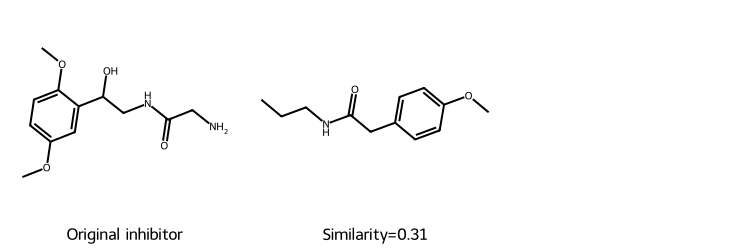

In [76]:
img[2]

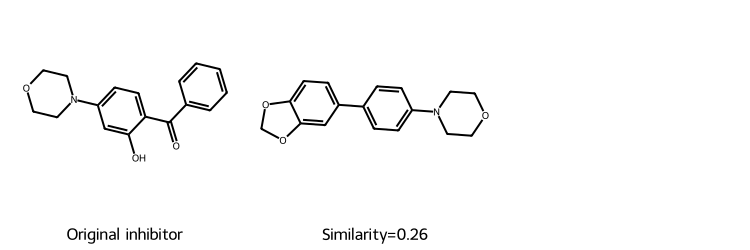

In [67]:
img[3]

# U test

In [44]:
def extract_sims_with_key(data, key):
#     max_morgan_fp_tanimoto_sim = [value['max_morgan_fp_tanimoto_sim'] for value in data.values()]
#     max_maccs_fp_tanimoto_sim = [value['max_maccs_fp_tanimoto_sim'] for value in data.values()]
#     max_fraggle_sim = [value['max_fraggle_sim'] for value in data.values()]
    max_sim = [value[key] for value in data.values()]
    return max_sim

In [34]:
maccs_sim = {
    "ldm_vae":extract_sims_with_key(ldm_vae_data, 'max_maccs_fp_tanimoto_sim'),
    "ldm_aae":extract_sims_with_key(ldm_aae_data, 'max_maccs_fp_tanimoto_sim'),
    "ldm_wae":extract_sims_with_key(ldm_wae_data, 'max_maccs_fp_tanimoto_sim'),
}
maccs_sim

{'ldm_vae': [0.6060606060606061,
  0.5084745762711864,
  0.5238095238095238,
  0.5909090909090909,
  0.5797101449275363,
  0.55,
  0.5362318840579711,
  0.5645161290322581,
  0.55,
  0.5076923076923077,
  0.6231884057971014,
  0.4603174603174603,
  0.532258064516129,
  0.453125,
  0.4444444444444444,
  0.4492753623188406,
  0.5,
  0.42028985507246375,
  0.5370370370370371,
  0.47619047619047616,
  0.4925373134328358,
  0.4307692307692308,
  0.5272727272727272,
  0.46551724137931033,
  0.5081967213114754,
  0.5192307692307693,
  0.5882352941176471,
  0.515625,
  0.5283018867924528,
  0.48148148148148145,
  0.4716981132075472,
  0.4666666666666667,
  0.54,
  0.5370370370370371,
  0.5,
  0.48484848484848486,
  0.5166666666666667,
  0.5,
  0.5471698113207547,
  0.5,
  0.46938775510204084,
  0.6041666666666666,
  0.64,
  0.5102040816326531,
  0.5925925925925926,
  0.55,
  0.5961538461538461,
  0.46153846153846156,
  0.5,
  0.5490196078431373,
  0.4897959183673469,
  0.5166666666666667,
  0.

In [45]:
tgt

m_fp_tanimoto_sim maccs_fp_tanimoto_sim fraggle_sims    dist_type
0             0.185567              0.592593     0.661417      ldm_vae
1             0.290909              0.716418     0.801527      ldm_vae
2             0.172414              0.551724     0.540698      ldm_vae
3             0.234568              0.540984     0.573248      ldm_vae
4             0.204819                  0.56     0.477157      ldm_vae
...                ...                   ...          ...          ...
2277          0.108108              0.357143     0.310078  cosine_dist
2514          0.104839                  0.56     0.280265  cosine_dist
2063          0.064748              0.373333     0.274823  cosine_dist
2059          0.067797              0.308824     0.318627  cosine_dist
3066          0.068376              0.204545     0.265683  cosine_dist

[1992 rows x 4 columns]

In [44]:
from scipy.stats import mannwhitneyu

In [45]:
vae_maccs = tgt['maccs_fp_tanimoto_sim'].loc[tgt['dist_type']=='ldm_vae'].values
vae_maccs = vae_maccs.astype('float')
vae_maccs

array([], dtype=float64)

In [46]:
euc_maccs = tgt['maccs_fp_tanimoto_sim'].loc[tgt['dist_type']=='euclidean_dist'].values
euc_maccs = euc_maccs.astype('float')
euc_maccs

array([0.4       , 0.46835443, 0.53846154, 0.39215686, 0.21333333,
       0.48148148, 0.44155844, 0.30769231, 0.30769231, 0.46666667,
       0.30769231, 0.25882353, 0.27027027, 0.38554217, 0.4137931 ,
       0.30666667, 0.59302326, 0.59302326, 0.34177215, 0.30769231,
       0.38636364, 0.26086957, 0.61333333, 0.3253012 , 0.43661972,
       0.32258065, 0.38297872, 0.52777778, 0.26666667, 0.37878788,
       0.4084507 , 0.55555556, 0.36666667, 0.57971014, 0.43023256,
       0.40322581, 0.3       , 0.55405405, 0.47058824, 0.28235294,
       0.55421687, 0.54929577, 0.54929577, 0.56944444, 0.36708861,
       0.47297297, 0.26666667, 0.45348837, 0.57142857, 0.38271605,
       0.17045455, 0.38356164, 0.24074074, 0.4       , 0.46666667,
       0.5625    , 0.32432432, 0.30769231, 0.43478261, 0.47368421,
       0.35897436, 0.35714286, 0.42666667, 0.25373134, 0.47560976,
       0.33333333, 0.3015873 , 0.2       , 0.7962963 , 0.48387097,
       0.29230769, 0.625     , 0.55952381, 0.3125    , 0.58333

In [47]:
u1, p = mannwhitneyu(vae_maccs, euc_maccs, alternative='greater')
p

ValueError: `x` and `y` must be of nonzero size.

In [48]:
x_type = ['ldm_vae', 'ldm_aae', 'ldm_wae']
# x_type = ['LDM(ours)']
y_type = ['biaae', 'euclidean_dist', 'cosine_dist']
sim_type = ['m_fp_tanimoto_sim', 'maccs_fp_tanimoto_sim', 'fraggle_sims']

In [49]:
p_dict = {}
for sim in sim_type:
    p_dict[sim] = {} 
    for x in x_type:
        for y in y_type:
           
            x_data = tgt[sim].loc[tgt['dist_type']==x].values
            x_data = x_data.astype('float')
            y_data = tgt[sim].loc[tgt['dist_type']==y].values   
            y_data = y_data.astype('float')
            
            print(x_data, y_data)
            u1, p = mannwhitneyu(x_data, y_data, alternative='greater')
            name = x+'-'+y
            p_dict[sim][name] = p

[] []


ValueError: `x` and `y` must be of nonzero size.

In [52]:
p_dict

{'m_fp_tanimoto_sim': {'ldm_vae-biaae': 0.019243243380970085,
  'ldm_vae-euclidean_dist': 7.662863547584994e-76,
  'ldm_vae-cosine_dist': 2.4577697541142272e-89,
  'ldm_aae-biaae': 0.9999999999770639,
  'ldm_aae-euclidean_dist': 2.3730471227398894e-65,
  'ldm_aae-cosine_dist': 1.857604359410911e-76,
  'ldm_wae-biaae': 0.2278581789976496,
  'ldm_wae-euclidean_dist': 3.449262197918828e-75,
  'ldm_wae-cosine_dist': 7.767686436386934e-89},
 'maccs_fp_tanimoto_sim': {'ldm_vae-biaae': 1.0,
  'ldm_vae-euclidean_dist': 1.2145107467654828e-51,
  'ldm_vae-cosine_dist': 2.3673036508371217e-51,
  'ldm_aae-biaae': 0.9651695880618246,
  'ldm_aae-euclidean_dist': 2.4029679297347835e-62,
  'ldm_aae-cosine_dist': 1.7616005358856104e-64,
  'ldm_wae-biaae': 0.9922965987378762,
  'ldm_wae-euclidean_dist': 1.1106693677787402e-62,
  'ldm_wae-cosine_dist': 4.629513973096662e-65},
 'fraggle_sims': {'ldm_vae-biaae': 0.9995000082155892,
  'ldm_vae-euclidean_dist': 2.716856077327888e-41,
  'ldm_vae-cosine_dist':

In [53]:
p_df = pd.DataFrame.from_dict(p_dict)
p_df

m_fp_tanimoto_sim  maccs_fp_tanimoto_sim  fraggle_sims
ldm_vae-biaae                1.924324e-02           1.000000e+00  9.995000e-01
ldm_vae-euclidean_dist       7.662864e-76           1.214511e-51  2.716856e-41
ldm_vae-cosine_dist          2.457770e-89           2.367304e-51  1.298664e-53
ldm_aae-biaae                1.000000e+00           9.651696e-01  1.966252e-01
ldm_aae-euclidean_dist       2.373047e-65           2.402968e-62  2.727934e-58
ldm_aae-cosine_dist          1.857604e-76           1.761601e-64  1.573017e-74
ldm_wae-biaae                2.278582e-01           9.922966e-01  1.895291e-01
ldm_wae-euclidean_dist       3.449262e-75           1.110669e-62  3.823641e-57
ldm_wae-cosine_dist          7.767686e-89           4.629514e-65  6.721943e-73